# Compilers: Numba, Cython, pybind11

Speeding things up through parallel processing is called "horizontal scaling." Often, analysis code can be accelerated on a single thread as well, known as "vertical scaling."

Horizontal and vertical scaling are complementary: their effects are multiplicative.

Let's illustrate this with the fractal example from last time.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import time

def run_numpy(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]  # ask Numpy to make an x, y grid for us
    c = x + y*1j                                         # c is a constant: a grid of complex coordinates
    z = c
    fractal = numpy.zeros(c.shape, dtype=numpy.int32) + maxiterations   # the fractal image starts as "20" everywhere
    for i in range(maxiterations):
        z = z**2 + c                                     # iteratively apply z -> z**2 + c
        diverge = numpy.absolute(z) > 2                  # define "divergence" by |z| > 2
        divnow = diverge & (fractal == maxiterations)    # the pixels that are diverging in this iteration
        fractal[divnow] = i                              # the fractal image is a plot of the iteration number
        z[diverge] = 2                                   # clamp to 2 so they don't diverge too much
    return fractal

Stare at this code: it performs operations across the whole grid, identifies pixels that have diverged, and repeats everything 20 times, even though the parts that have already diverged are "done."

More significant than the unnecessary work, though, is the memory movement. Each `z**2 + c` creates new intermediate arrays, moving a lot of memory, flushing CPU caches. Nowadays, mathematical operations are much faster than memory movement.

It may help to see how the image changes with number of iterations.

In [12]:
starttime = time.time()
fractal = run_numpy(800, 1200, maxiterations=20)
time.time() - starttime

1.4801783561706543

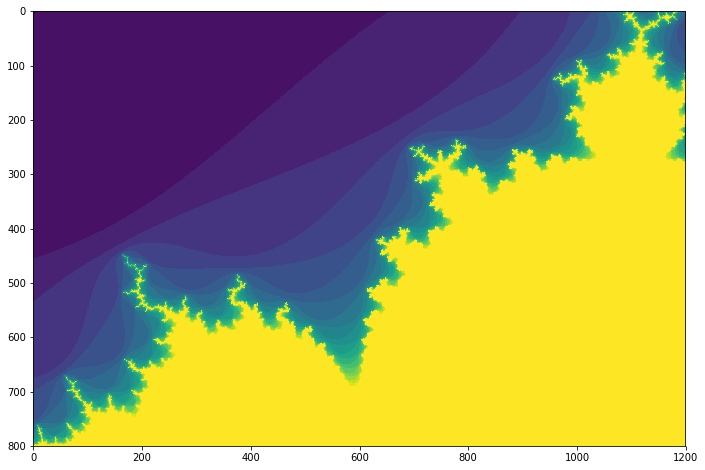

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(fractal)
# ax.imshow(fractal[-2000:, :3000])

If we weren't using Numpy, we'd write the algorithm differently: we'd deal with one pixel at a time. Once the pixel has diverged, we'd move on to the next, saving some work. But more importantly, we make only one pass over the image, avoiding unnecessary memory access.

In [28]:
def run_python(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.zeros(c.shape, dtype=numpy.int32) + maxiterations
    for h in range(height):
        for w in range(width):
            z = c[h, w]
            for i in range(maxiterations):
                z = z**2 + c[h, w]
                if abs(z) > 2:
                    fractal[h, w] = i
                    break
    return fractal

In [31]:
starttime = time.time()
fractal = run_python(800, 1200, maxiterations=20)
time.time() - starttime

43.218034982681274

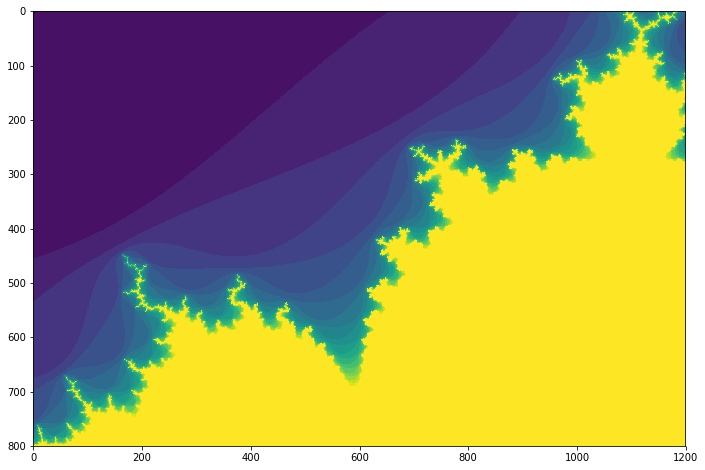

In [32]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(fractal)
# ax.imshow(fractal[-2000:, :3000])

It works, but it's _super slow!_ This is how an efficient algorithm would go, but stepping through each pixel in Python code kills performance due to all the type-checking, numeric boxing, and virtualization.

At this point, we'd normally start thinking about compiled code.